# Run Sandwich Attacks on Swaps from the Public Mempool

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import math

current_path = sys.path[0]
sys.path.append(
    current_path[: current_path.find("defi-measurement")]
    + "liquidity-distribution-history"
)

sys.path.append("..")


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from datetime import datetime, timezone


# Set display options
pd.set_option('display.max_colwidth', None)  # Display entire cell content
pd.set_option('display.max_rows', 50)    # Display all rows
pd.set_option('display.max_columns', None) # Display all columns


from dotenv import load_dotenv
from pool_state import v3Pool
from sqlalchemy import create_engine
from tqdm import tqdm

load_dotenv(override=True)
# from experiments.random_permutations import load_pool

from experiments.preload_pool_cache import load_pool_from_blob


from decimal import getcontext

getcontext().prec = 100  # Set the precision high enough for our purposes


# Read in the environment variables
postgres_uri_mp = os.environ["POSTGRESQL_URI_MP"]
postgres_uri_us = os.environ["POSTGRESQL_URI_US"]
azure_storage_uri = os.environ["AZURE_STORAGE_CONNECTION_STRING"]


## Get the Data

In [3]:
engine = create_engine(postgres_uri_mp)

query = """
SELECT *
FROM SWAP_LIMIT_PRICE AS LIM
INNER JOIN MEMPOOL_TRANSACTIONS AS MEM ON LIM.transaction_hash = MEM.HASH
"""

# col_rename = dict(
#     call_block_number='block_number',
#     contract_address='pool',
# )

# df = pd.read_sql_query(query, engine).rename(columns=col_rename).sort_values(by=['pool', 'block_number'])
df = pd.read_sql_query(query, engine)

df

,transaction_type,transaction_hash,recipient,amountIn,amountOut,amountOutMin,amountInMax,payerIsUser,token0,fee,token1,pool,hash,first_seen
0,V3_SWAP_EXACT_IN,0xf994fffef07171ffd55740b211588979d8745a964f24b1c137fa2cd5874536a2,0x0000000000000000000000000000000000000001,2300000000000000000,None,20720352176690778061354,None,false,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3000,0x046eee2cc3188071c02bfc1745a6b17c656e3f3d,0x510100d5143e011db24e2aa38abe85d73d5b2177,0xf994fffef07171ffd55740b211588979d8745a964f24b1c137fa2cd5874536a2,2023-08-11 18:39:57.688000+00:00
1,V3_SWAP_EXACT_IN,0x68e616c69d7fc23d8669221616130baee931bb438d4aa8a686d88d390cda5323,0x0000000000000000000000000000000000000001,220000000000000000,None,1939764922511645684352,None,false,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3000,0x046eee2cc3188071c02bfc1745a6b17c656e3f3d,0x510100d5143e011db24e2aa38abe85d73d5b2177,0x68e616c69d7fc23d8669221616130baee931bb438d4aa8a686d88d390cda5323,2023-08-11 18:36:06.730000+00:00
2,V3_SWAP_EXACT_IN,0x4f5aa8d66ab6404c628dd498979489cb173df77ed8078edf736e183d41e82dae,0x0000000000000000000000000000000000000001,300000000000000000,None,2686021351206594973990,None,false,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3000,0x046eee2cc3188071c02bfc1745a6b17c656e3f3d,0x510100d5143e011db24e2aa38abe85d73d5b2177,0x4f5aa8d66ab6404c628dd498979489cb173df77ed8078edf736e183d41e82dae,2023-08-11 18:35:33.257000+00:00
3,V3_SWAP_EXACT_IN,0xbdbebc9d69e98aef757fc1c24ea1cf9f513f9aba3484749f070124fabf674256,0x0000000000000000000000000000000000000002,2500000000000000000000,None,270568229649369198,None,true,0x046eee2cc3188071c02bfc1745a6b17c656e3f3d,3000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x510100d5143e011db24e2aa38abe85d73d5b2177,0xbdbebc9d69e98aef757fc1c24ea1cf9f513f9aba3484749f070124fabf674256,2023-08-11 18:30:36.115000+00:00
4,V3_SWAP_EXACT_IN,0x7b78d768aa6cfe6f56b1fbbee88190ebe2916a37d6b9044476945d773fa24e89,0x0000000000000000000000000000000000000001,110000000000000000,None,973957923669322643285,None,false,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3000,0x046eee2cc3188071c02bfc1745a6b17c656e3f3d,0x510100d5143e011db24e2aa38abe85d73d5b2177,0x7b78d768aa6cfe6f56b1fbbee88190ebe2916a37d6b9044476945d773fa24e89,2023-08-11 18:29:20.280000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34304,V3_SWAP_EXACT_IN,0xeb7a49a9921b543fcb913e18ae01edc5224ded3928483be60c840146c645c0af,0x0000000000000000000000000000000000000002,2524582283050016063314,None,103133931153910731,None,true,0x3506424f91fd33084466f402d5d97f05f8e3b4af,10000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x325365ed8275f6a74cac98917b7f6face8da533b,0xeb7a49a9921b543fcb913e18ae01edc5224ded3928483be60c840146c645c0af,2023-08-05 00:53:48.551000+00:00
34305,V3_SWAP_EXACT_IN,0x9813cb62b75b03395c67ff919277825581b10fd0dcb877a55c72d34202a60089,0x0000000000000000000000000000000000000001,2500000000000000,None,417998905226446063984,None,false,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3000,0x001a8ffcb0f03e99141652ebcdecdb0384e3bd6c,0xf766436b551d2acb09b73d126fd49869541dfa26,0x9813cb62b75b03395c67ff919277825581b10fd0dcb877a55c72d34202a60089,2023-08-04 23:38:32.946000+00:00
34306,V3_SWAP_EXACT_IN,0xf6f3de23aa19144a456cd8c8812b2dbe7390a80482e903991e025eec1e874f3a,0x0000000000000000000000000000000000000002,757397629026218297029,None,38646185738092907,None,true,0xc5bcc8ba3f33ab0d64f3473e861bdc0685b19ef5,10000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xfde61ea5a1c8827f0c83e1b3c05a3cdefed8a8db,0xf6f3de23aa19144a456cd8c8812b2dbe7390a80482e903991e025eec1e874f3a,2023-08-05 00:21:11.999000+00:00
34307,V3_SWAP_EXACT_IN,0xf4c22504de2e141335421b728ff015bf11c9f3b677e32d53bfbce32d8eb5a980,0x0000000000000000000000000000000000000002,836623000000000000000000,None,68460438323977550,None,true,0x24ae124c4cc33d6791f8e8b63520ed7107ac8b3e,3000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xd2ef54450ec52347bde3dab7b086bf2a005601d8,0xf4c22504de2e141335421b728ff015bf11c9f3b677e32d53bfbce32d8eb5a980,2023-08-04 23:33:38.843000+00:00


### Populate the swap data we have with the block number that the swap appeared in

In [4]:
engine = create_engine(postgres_uri_us)

block_numbers = pd.read_sql_query(
    """
    SELECT block_number, tx_hash, block_ts
    FROM swaps
    WHERE block_number >= 17400000
    ORDER BY block_ts ASC
    """,
    engine
).set_index('tx_hash')


In [5]:
block_number_dict = block_numbers[~block_numbers.index.duplicated(keep='first')].to_dict(orient="index")

In [6]:
dataset = df.assign(block_number=df.transaction_hash.map(lambda x: block_number_dict[x]['block_number'] if x in block_number_dict else None))
dataset = dataset[~dataset.block_number.isna()]


In [7]:
swap_counts = dataset.groupby(by=['pool', 'block_number'])[['transaction_hash']].count().sort_values('transaction_hash', ascending=False)

swap_counts[swap_counts == 1].transaction_hash.sum(), swap_counts[swap_counts > 1].transaction_hash.sum(), swap_counts.transaction_hash.sum()

(1115.0, 8.0, 1123)

## Create Sandwich Attacks on Single Swaps

Start with this to validate the approach.

In [8]:
single_swap_blocks = swap_counts[swap_counts == 1].sort_index()

df_single = dataset.set_index(['pool', 'block_number']).loc[single_swap_blocks.index]

# Group by level 0 and count unique values in level 1
grouped_counts = df_single.groupby(level=0).apply(lambda x: x.index.get_level_values(1).nunique())

# Sort the indices based on the counts
sorted_indices = grouped_counts.sort_values(ascending=False).index

# Reindex the DataFrame based on this sorted order
df_single_sorted = df_single.loc[sorted_indices]


df_single_sorted

transaction_type  \
pool                                       block_number                     
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17844881.0    V3_SWAP_EXACT_IN   
                                           17844904.0    V3_SWAP_EXACT_IN   
                                           17845667.0    V3_SWAP_EXACT_IN   
                                           17845763.0    V3_SWAP_EXACT_IN   
                                           17845997.0    V3_SWAP_EXACT_IN   
...                                                                   ...   
0x824a30f2984f9013f2c8d0a29c0a3cc5fd5c0673 17851468.0    V3_SWAP_EXACT_IN   
0x2519042aa735edb4688a8376d69d4bb69431206c 17860223.0    V3_SWAP_EXACT_IN   
0x84383fb05f610222430f69727aa638f8fdbf5cc1 17860950.0    V3_SWAP_EXACT_IN   
0x8592064903ef23d34e4d5aaaed40abf6d96af186 17861372.0    V3_SWAP_EXACT_IN   
0x0188c28ea32d7860334be1a8068cfbadce18f1d9 17853849.0    V3_SWAP_EXACT_IN   

                                                                                                           transaction_hash  \
pool                                       block_number                                                                       
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17844881.0    0x9b725af94aeee29b275de52f7c24daa0eae7e5307005c658c5f34899035d89ee   
                                           17844904.0    0x14b5685befba09b42d2fe0f6cc7c2b0c3fd0764355f2e1fe908dd132aa324e4d   
                                           17845667.0    0xe2a288a88564e946aa9bf295d2356d3845fc48d42732710f91c2449f81cd3798   
                                           17845763.0    0xd8b8bbc709e03d77db68563fd16abd9caaf3b8d851a4c6e50ac597582788b9e2   
                                           17845997.0    0xb993834ce53cc8cec95ef92af13a3ac04dedf4cd9c954bc0ce708e78ca98f7ad   
...                                                                                                                     ...   
0x824a30f2984f9013f2c8d0a29c0a3cc5fd5c0673 17851468.0    0x470622c876dc89d5fa0dfde9cf9fe6633ceaa3085393527c1ab8d2dcbeed3c1d   
0x2519042aa735edb4688a8376d69d4bb69431206c 17860223.0    0xa79792dbe256b736e0e7bee05c5396a8f35914fc9591f3f64ee580ebaaf9cdf8   
0x84383fb05f610222430f69727aa638f8fdbf5cc1 17860950.0    0x7315d085c6e0eabe2fd192d778ad55dc84dbd436eb6d8ca919a57a3f0f619777   
0x8592064903ef23d34e4d5aaaed40abf6d96af186 17861372.0    0x99569ef3912b419a6e779951d696f82f714f7f6469e2a4613822580739f37f37   
0x0188c28ea32d7860334be1a8068cfbadce18f1d9 17853849.0    0x4f7dea75e57c80506fd03dfb35edfce4ed1a67a773e84cff7e515bd915b29053   

                                                                                          recipient  \
pool                                       block_number                                               
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17844881.0    0x0000000000000000000000000000000000000001   
                                           17844904.0    0x0000000000000000000000000000000000000001   
                                           17845667.0    0x0000000000000000000000000000000000000002   
                                           17845763.0    0xa8f308ab910027c5245dcfb9a5eca02444a35499   
                                           17845997.0    0x0000000000000000000000000000000000000001   
...                                                                                             ...   
0x824a30f2984f9013f2c8d0a29c0a3cc5fd5c0673 17851468.0    0x0000000000000000000000000000000000000002   
0x2519042aa735edb4688a8376d69d4bb69431206c 17860223.0    0x0000000000000000000000000000000000000002   
0x84383fb05f610222430f69727aa638f8fdbf5cc1 17860950.0    0x0000000000000000000000000000000000000001   
0x8592064903ef23d34e4d5aaaed40abf6d96af186 17861372.0    0x0000000000000000000000000000000000000001   
0x0188c28ea32d7860334be1a8068cfbadce18f1d9 17853849.0    0x0000000000000000000000000000000000000001   

                                                               

In [9]:
# Keep only the swap in subset for now
df_single_sorted = df_single_sorted[df_single_sorted.transaction_type == 'V3_SWAP_EXACT_IN'].drop(columns=['transaction_type', 'recipient', 'amountOut', 'amountInMax', 'payerIsUser', 'transaction_hash'])

## Get a pool and do some initial testing

In [10]:
def to_price(inv_sqrt_price):
    return 1/(inv_sqrt_price)**2 * 1e12

In [11]:
pool: v3Pool = load_pool_from_blob(
    "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640",
    postgres_uri_us,
    azure_storage_uri,
    "uniswap-v3-pool-cache",
    verbose=True,
    invalidate_before_date=datetime(2023, 8, 15, tzinfo=timezone.utc),
)

Loading pool from Azure blob storage cache


In [12]:
orig_fee = pool.fee

orig_fee

0.0005

In [13]:
pool.fee = orig_fee
# pool.fee = 0

In [14]:
from dataclasses import dataclass
from datetime import datetime
from typing import Union

@dataclass
class SwapData:
    pool: str
    block_number: float
    amountIn: str
    amountOutMin: str
    token0: str
    fee: str
    token1: str
    hash: str
    first_seen: Union[datetime, None]
    # eth_in_float: float


In [15]:
def valid_frontrun(pool: v3Pool, swap: SwapData, frontrun_input) -> bool:
    try:
        curr_price = pool.getPriceAt(swap.block_number)

        swap_params = {
            "input": frontrun_input,
            "tokenIn": swap.token0,
            "as_of": swap.block_number,
            "gasFee": True,
            "givenPrice": curr_price,
        }

        _, heur = pool.swapIn(swap_params)

        swap_params = {
            "input": int(swap.amountIn),
            "tokenIn": swap.token0,
            "as_of": swap.block_number,
            "gasFee": True,
            "givenPrice": heur.sqrtP_next,
        }

        output, heur = pool.swapIn(swap_params)

        return output >= int(swap.amountOutMin)
    
    except AssertionError:
        print("Assertion error in [valid_frontrun], return False")
        return False


def exponential_search(pool: v3Pool, swap: SwapData, start=1e6, max_tries=100, factor=8) -> (int, int):
    lower = 0
    upper = start
    
    for i in range(max_tries):
        # print(f"{i}: Trying {upper / 1e18}")
        if not valid_frontrun(pool, swap, upper):
            return lower, upper
        else:
            lower = upper
            upper *= factor

    else:
        raise Exception("Exponential search exceeded max tries")
    
def binary_search(pool: v3Pool, swap: SwapData, lower, upper, max_tries=100) -> int:
    for i in range(max_tries):
        # print(f"{i}: Trying {lower / 1e18} - {upper / 1e18}")
        if math.isclose(lower, upper, abs_tol=1e18):
            return lower
        
        mid = (lower + upper) // 2
        if valid_frontrun(pool, swap, mid):
            lower = mid
        else:
            upper = mid

    else:
        raise Exception("Binary search exceeded max tries")
    

def max_frontrun(pool: v3Pool, swap: SwapData, start=1e6, factor=2) -> int:
    lower, upper = exponential_search(pool, swap, start=start, factor=factor)
    return binary_search(pool, swap, lower, upper)
    

In [16]:
def single_sandwich_mev(pool: v3Pool, swap: SwapData, frontrun_input: int, pool_fee=True) -> (int, float):
    total_gas = 0
    if not pool_fee:
        orig_fee = pool.fee
        pool.fee = 0

    curr_price = pool.getPriceAt(swap.block_number)

    swap_params = {
        "input": frontrun_input,
        "tokenIn": swap.token0,
        "as_of": swap.block_number,
        "gasFee": True,
        "givenPrice": curr_price,
    }

    output_frontrun, heur = pool.swapIn(swap_params)
    total_gas += heur.gas_fee

    swap_params = {
        "input": int(swap.amountIn),
        "tokenIn": swap.token0,
        "as_of": swap.block_number,
        "gasFee": True,
        "givenPrice": heur.sqrtP_next,
    }

    output, heur = pool.swapIn(swap_params)
    swap_params = {
        "input": output_frontrun,
        "tokenIn": swap.token1,
        "as_of": swap.block_number,
        "gasFee": True,
        "givenPrice": heur.sqrtP_next,
    }

    output, heur = pool.swapIn(swap_params)
    total_gas += heur.gas_fee

    if not pool_fee:
        pool.fee = orig_fee

    return output - frontrun_input, total_gas


def auto_sandwich_mev(pool: v3Pool, swap: SwapData, start=1e18, factor=2, pool_fee=True) -> (int, float, int):
    frontrun_input = max_frontrun(pool, swap, start=start, factor=factor)
    profit, gas_fee = single_sandwich_mev(pool, swap, frontrun_input, pool_fee=pool_fee)
    return profit, gas_fee, frontrun_input

In [17]:
profits = {}

curr_pool = None

for swap_dict in tqdm(df_single_sorted.reset_index().to_dict(orient='records')):
    swap = SwapData(**swap_dict)

    if not curr_pool or curr_pool.pool != swap.pool:
        curr_pool: v3Pool = load_pool_from_blob(
            swap.pool,
            postgres_uri_us,
            azure_storage_uri,
            "uniswap-v3-pool-cache",
            verbose=True,
            invalidate_before_date=datetime(2023, 8, 16, tzinfo=timezone.utc),
        )

    profit, gas_fee, frontrun_input = auto_sandwich_mev(pool, swap, start=1e20, factor=4, pool_fee=True)
    profit_nofee, _ = single_sandwich_mev(pool, swap, frontrun_input, pool_fee=False)

    profits[swap.hash] = dict(
        block_number=swap.block_number,
        pool=swap.pool,
        profit=profit,
        profit_nofee=profit_nofee,
        gas_fee_eth=gas_fee,
        frontrun_input=frontrun_input,
    )

profits = pd.DataFrame.from_dict(profits, orient='index')

profits

  0%|          | 0/957 [00:00<?, ?it/s]

Blob is invalidated due to old modification date
Loading pool from database


  0%|          | 0/957 [02:06<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Given 17 seconds per sandwich, how many sandwiches can you make in a night?
hours_per_night = 8
seconds_per_sandwich = 17
cpus = 1

hours_per_night * 60 * 60 / seconds_per_sandwich * cpus

1694.1176470588234

## Graveyard


In [ ]:
swap_df.xInTick.cumsum().max() / 1e18

5.0802713739051496e+16

Initializing liquidity


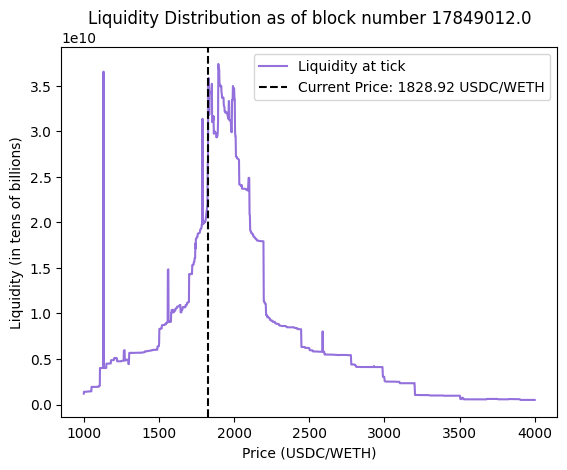

In [ ]:
########### INPUT BLOCK ###############
block_number          = 17849012.0
transaction_index     = 0
display_price_lower   = 1000
display_price_upper   = 4000

#######################################
def plot_liq(pool, block_number, transaction_index, display_price_lower, display_price_upper):
    as_of = block_number + transaction_index / 1e4
    x, y = pool.createLiq(as_of)
    x, y = np.array(x), np.array(y)
    px = pool.getPriceAt(as_of)
    liq_df = pd.DataFrame(x, columns=["ticks"])
    liq_df["liquidity"] = y
    liq_df['px'] = 1 / (1.0001 ** liq_df['ticks']) * 1e12

    plot_df = liq_df[(liq_df['px'] < display_price_upper) & (liq_df['px'] > display_price_lower)].set_index("px")

    fig, ax = plt.subplots()

    ax.plot(plot_df['liquidity'], label = "Liquidity at tick", color = 'mediumpurple')
    
    curr_price = (1 / px ** 2) * 1e12
    ax.axvline(curr_price, color='black', linestyle = "--", label=f"Current Price: {curr_price:.2f} USDC/WETH")
    ax.legend()
    ax.set_ylabel("Liquidity (in tens of billions)")
    ax.set_xlabel("Price (USDC/WETH)")
    ax.set_title(f'Liquidity Distribution as of block number {as_of}')

    plt.show()

plot_liq(pool, block_number, transaction_index, display_price_lower, display_price_upper)

In [ ]:
xs = []
ys_fee = []
ys_nofee = []

inp = 1e18

while inp < 2817*1e18:
    xs.append(inp)
    ys_fee.append(single_sandwich_mev(pool, swap, frontrun_input=inp, pool_fee=True) / 1e18)
    ys_nofee.append(single_sandwich_mev(pool, swap, frontrun_input=inp, pool_fee=False) / 1e18)

    inp *= 2

TypeError: unsupported operand type(s) for /: 'tuple' and 'float'

In [ ]:
max(ys_fee), max(ys_nofee)

(-0.000960385617632512, 0.11025033805037568)

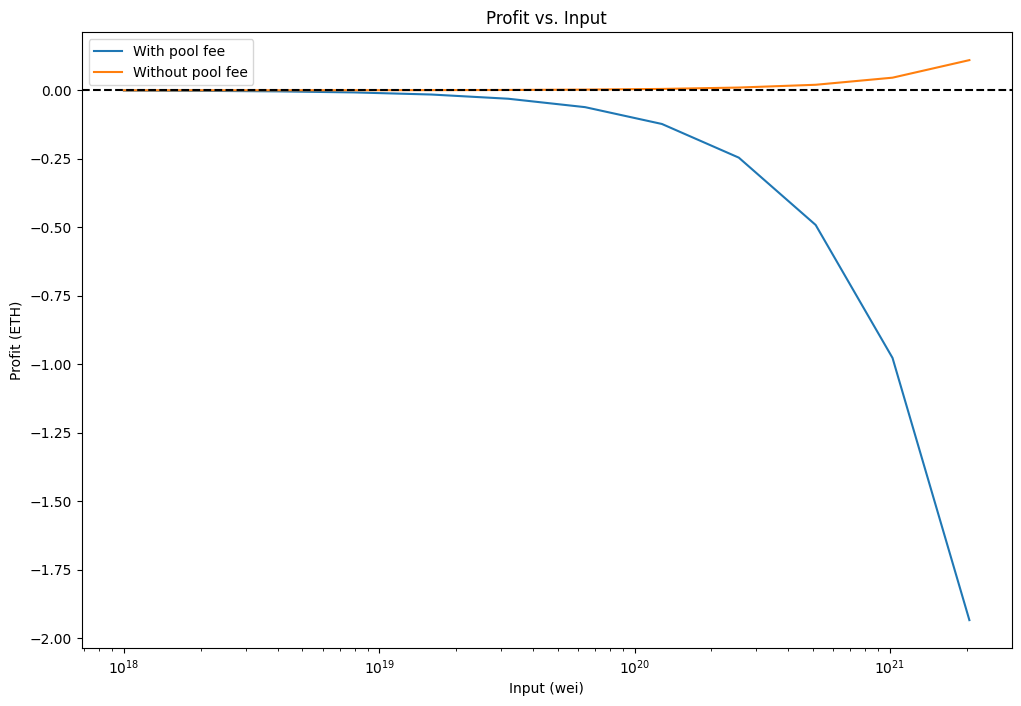

In [ ]:

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(xs, ys_fee, label="With pool fee")
ax.plot(xs, ys_nofee, label="Without pool fee")

ax.set_xscale("log")
# ax.set_yscale("log")

ax.set_xlabel("Input (wei)")
ax.set_ylabel("Profit (ETH)")

ax.set_title("Profit vs. Input")

# Add horizontal line at y=0
ax.axhline(y=0, color="black", linestyle="--")

ax.legend();